# Week 4 - Naive Bayes Inferencing and Classification
Week Four - August 15, 2022


Reminder, the author has all of the code available on [Github](https://github.com/joelgrus/data-science-from-scratch)

The data set is included in this repo, but sourced from [Kaggle](https://www.kaggle.com/datasets/bagavathypriya/spam-ham-dataset)

[A really good intro to Naive Bayes and Bayesian modeling from Veritasium](https://youtu.be/R13BD8qKeTg)

## Chapter 13 - Naive Bayes Modeling

### Review of Bayes Theorem and Creating a Decision Space
Recall the Bayesian formula: <code>P(Y|X) = P(X|Y) P(Y) / P(X)</code>

For a spam filter <code>Y = {spam, not_spam} </code>, and <code>X = {word_1, word_2, ... word_k} </code>

So, <code>P(spam | X) = P(X | spam) * P(spam) / P(X) </code>
Likewise, <code>P(not_spam | X) = P(X | not_spam) * P(not_spam) / P(X) </code>

So to predict if the email is spam or not, we want to compare <code>P(spam | X)</code> with <code>P(not_spam | X)</code> and go with the higher probability:

 <code> P(X | spam) * P(spam) / P(X) (?) P(X | not_spam) * P(not_spam) / P(X)</code>

Since both probabilities have the same denominator, we can eliminate it for numberical stability (and less computing).

<code> P(X | spam) * P(spam)  (?)  P(X | not_spam) * P(not_spam) </code>

### Bayesian Optimal Solutions - Theoretically the Best

"X" is really the set of all features, or for spam determination, the set of all word counts in the email set, so this is really:

<code> P(word_1, word_2, ..., word_k | spam) * P(spam)  (?)  P(word_1, word_2, ..., word_k  | not_spam) * P(not_spam) </code>

By the chain rule of probability this expands out (just showing the P(spam...) side for simplicity):

<code> P(spam) * P(word_1 | spam) *  P(word_1 | word_2, spam) * ... * (word_1 | word_2, ..., word_k, spam) * P(word_2 | spam) *  P(word_2 | word_1, spam) * ... * (word_2 | word_1, ..., word_k, spam) * ... </code>

This full expansion will give us **the absolutly most accurate classifier possible** called the _Bayesian Optimimal Solution_. However, it is unlikely we can really charactorize all the joint and conditional probabilities, and even if that was available in the data, it would be computationally intractable!  Therefore a _Bayesian Optimimal Solution_ is usually just considered as the theoretically ideal classifier and we need to use heuristic methods to approximate this optimal solution but with an algorithm that is tractable. 

### Assuming Independance between Features is Naive

We can leverage the usually inaccurate _independant and identically distributed_ (i.i.d.) assumption among the features. By _independant_ we will assume that for any two features _a_ and _b_ there is zero correlation between the two. This is a fairly naive assumption, but it turns out will serve well in this algorithm. By _identically distributed_ we will assume that each feature is equally weighted and no one feature is more important than any other in determining the label.

Despite these assumptions being naive, they still provide a remarkably accurate classifier.

### Numerical Stability

#### Log-Likelihood
Multiplying a lot of numbers between (0,1) tends to cause _underflow_ issues in computers, so we can take the  log of the probabilities to keep the numbers stable, and then take the exponent of the answer to conver back.

#### LaPlace Smoothing
 What if one of the probabilities is zero? That is, if there are no examples in the training data for one word in one of the classes/labels, then the P(y|x) := 0/|y| * P(y). In order to avoid this, we can either seed every token occurance with a small starting value, or catch any zero-valued probabilities and substitute it with a rather small _alpha_ value (e.g., 1E-7). [See this article for a deeper dive](https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece)
 
 

'conda' is not recognized as an internal or external command,
operable program or batch file.
'conda' is not recognized as an internal or external command,
operable program or batch file.


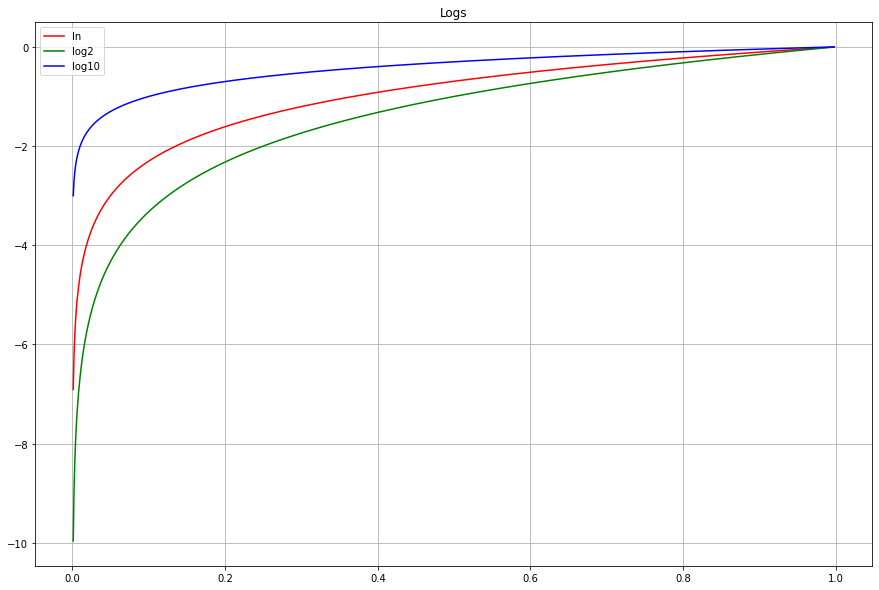

In [6]:
import math, sys
!conda install --yes --prefix {sys.prefix} matplotlib
!conda install --yes --prefix {sys.prefix} tqdm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

x = [i / 1000.0 for i in range(1,999)]
y1 = [math.log(i) for i in x]
y2 = [math.log2(i) for i in x]
y3 = [math.log10(i) for i in x]
fig, ax = plt.subplots()
ax.plot(x, y1, color='r', label='ln')
ax.plot(x, y2, color='g', label='log2')
ax.plot(x, y3, color='b', label='log10')
plt.gcf().set_size_inches(15,10)
#plt.xlabel("This is the x-axis for independant variables")
#plt.ylabel("This is the y-axis for dependant variables")
plt.title("Logs")
plt.grid(True, which='both')
plt.legend()
plt.show()

### Code from the Book
 Also look at the [discussion](https://scikit-learn.org/stable/modules/naive_bayes.html) and [implementation](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/naive_bayes.py) from Scikit-learn's library for real-world usage.

In [26]:
# Attribution: https://github.com/joelgrus/data-science-from-scratch/blob/master/scratch/naive_bayes.py

from typing import Set, NamedTuple, List, Tuple, Dict, Iterable
from collections import defaultdict
import glob, re, random, math
from scratch.machine_learning import split_data 

def tokenize(text: str) -> Set[str]:
    text = text.lower()                            # Convert to lowercase,
    all_words = re.findall("[a-z0-9\&'-]+", text)  # extract the words, and
    return set(all_words)                          # remove duplicates.

assert tokenize("Data Science is science") == {"data", "science", "is"}


class Message(NamedTuple):
    text: str
    is_spam: bool

 
class NaiveBayesClassifier:
    def __init__(self, k: float = 0.5) -> None:
        self.k = k  # smoothing factor

        self.tokens: Set[str] = set()
        self.token_spam_counts: Dict[str, int] = defaultdict(int)
        self.token_ham_counts: Dict[str, int] = defaultdict(int)
        self.spam_messages = self.ham_messages = 0

    def train(self, messages: Iterable[Message]) -> None:
        for message in messages:
            # Increment message counts
            if message.is_spam:
                self.spam_messages += 1
            else:
                self.ham_messages += 1

            # Increment word counts
            for token in tokenize(message.text):
                self.tokens.add(token)
                if message.is_spam:
                    self.token_spam_counts[token] += 1
                else:
                    self.token_ham_counts[token] += 1

    def _probabilities(self, token: str) -> Tuple[float, float]:
        """returns P(token | spam) and P(token | not spam)"""
        spam = self.token_spam_counts[token]
        ham = self.token_ham_counts[token]

        p_token_spam = (spam + self.k) / (self.spam_messages + 2 * self.k)
        p_token_ham = (ham + self.k) / (self.ham_messages + 2 * self.k)

        return p_token_spam, p_token_ham

    def predict(self, text: str) -> float:
        text_tokens = tokenize(text)
        log_prob_if_spam = log_prob_if_ham = 0.0

        # Iterate through each word in our vocabulary.
        for token in self.tokens:
            prob_if_spam, prob_if_ham = self._probabilities(token)

            # If *token* appears in the message,
            # add the log probability of seeing it;
            if token in text_tokens:
                log_prob_if_spam += math.log(prob_if_spam)
                log_prob_if_ham += math.log(prob_if_ham)

            # otherwise add the log probability of _not_ seeing it
            # which is log(1 - probability of seeing it)
            else:
                log_prob_if_spam += math.log(1.0 - prob_if_spam)
                log_prob_if_ham += math.log(1.0 - prob_if_ham)

        prob_if_spam = math.exp(log_prob_if_spam)
        prob_if_ham = math.exp(log_prob_if_ham)
        return prob_if_spam / (prob_if_spam + prob_if_ham)

messages = [Message("spam rules", is_spam=True),
            Message("ham rules", is_spam=False),
            Message("hello ham", is_spam=False)]

model = NaiveBayesClassifier(k=0.5)
model.train(messages)

assert model.tokens == {"spam", "ham", "rules", "hello"}
assert model.spam_messages == 1
assert model.ham_messages == 2
assert model.token_spam_counts == {"spam": 1, "rules": 1}
assert model.token_ham_counts == {"ham": 2, "rules": 1, "hello": 1}

text = "hello spam"

probs_if_spam = [
    (1 + 0.5) / (1 + 2 * 0.5),      # "spam"  (present)
    1 - (0 + 0.5) / (1 + 2 * 0.5),  # "ham"   (not present)
    1 - (1 + 0.5) / (1 + 2 * 0.5),  # "rules" (not present)
    (0 + 0.5) / (1 + 2 * 0.5)       # "hello" (present)
]

probs_if_ham = [
    (0 + 0.5) / (2 + 2 * 0.5),      # "spam"  (present)
    1 - (2 + 0.5) / (2 + 2 * 0.5),  # "ham"   (not present)
    1 - (1 + 0.5) / (2 + 2 * 0.5),  # "rules" (not present)
    (1 + 0.5) / (2 + 2 * 0.5),      # "hello" (present)
]

p_if_spam = math.exp(sum(math.log(p) for p in probs_if_spam))
p_if_ham = math.exp(sum(math.log(p) for p in probs_if_ham))

# Should be about 0.83
assert model.predict(text) == p_if_spam / (p_if_spam + p_if_ham)

def drop_final_s(word):
    return re.sub("s$", "", word)


  
# modify the path to wherever you've put the files
path = 'data/*amdata.csv'
  
data: List[Message] = []
    
# glob.glob returns every filename that matches the wildcarded path
for filename in glob.glob(path):
    
    is_spam = "ham" not in filename
    
    # There are some garbage characters in the emails, the errors='ignore'
    # skips them instead of raising an exception.
    with open(filename, errors='ignore') as email_file:
        for line in email_file:
                # The book used files per email. This data set is email per line
                data.append(Message(line, is_spam))
                #break  # done with this file
    print("Read input from file %s of %i lines" % (filename, len(data)))

    
random.seed(0)      # just so you get the same answers as me
train_messages, test_messages = split_data(data, 0.75)
    
model = NaiveBayesClassifier()
model.train(train_messages)
    
from collections import Counter
    
predictions = [(message, model.predict(message.text))
               for message in test_messages]
    
# Assume that spam_probability > 0.5 corresponds to spam prediction
# and count the combinations of (actual is_spam, predicted is_spam)
confusion_matrix = Counter((message.is_spam, spam_probability > 0.5)
                           for message, spam_probability in predictions)
    
print(confusion_matrix)
   
def p_spam_given_token(token: str, model: NaiveBayesClassifier) -> float:
    # We probably shouldn't call private methods, but it's for a good cause.
    prob_if_spam, prob_if_ham = model._probabilities(token)
    
    return prob_if_spam / (prob_if_spam + prob_if_ham)
    
words = sorted(model.tokens, key=lambda t: p_spam_given_token(t, model))

print("\n")
print("Training set size: ", len(train_messages) )
print("Total words/features: ", len(model.tokens))
print("spammiest_words", words[-10:])
print("hammiest_words", words[:10])
    


Read input from file data\hamdata.csv of 4827 lines
Read input from file data\spamdata.csv of 5574 lines
Counter({(False, False): 1203, (True, True): 165, (True, False): 24, (False, True): 2})


Training set size:  4180
Total words/features:  7896
spammiest_words ['awarded', 'tone', '500', 'guaranteed', '18', 'uk', '150p', 'won', 'prize', 'claim']
hammiest_words ['&lt', '&gt', "i'll", 'he', 'lor', 'da', 'later', 'much', 'she', 'way']


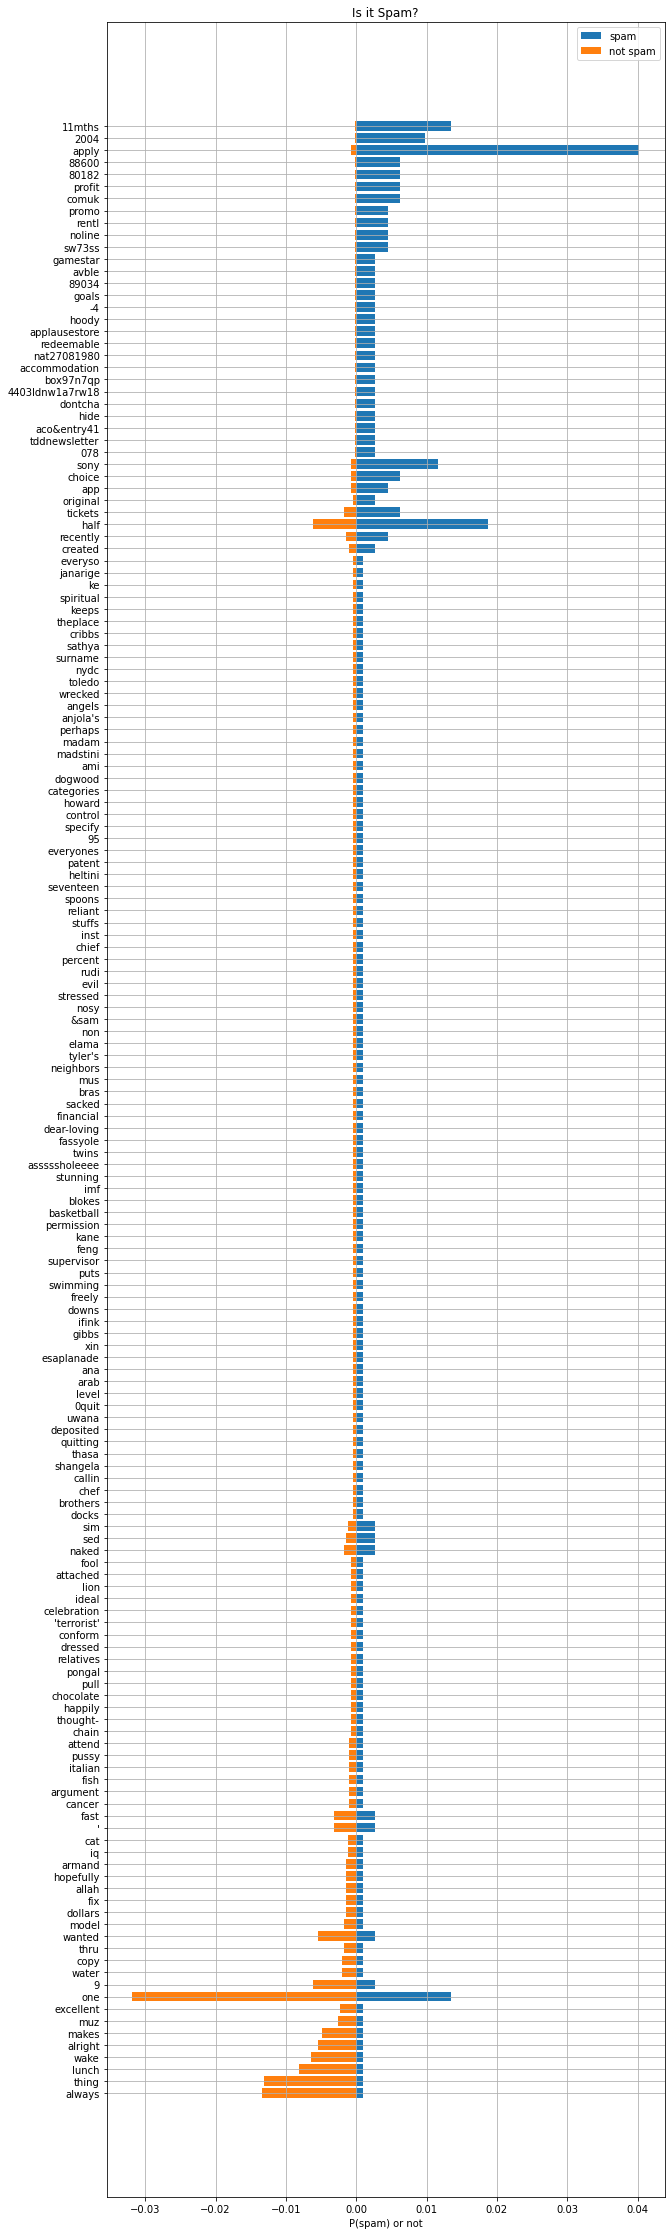

In [36]:
labels = []
results_spam = []
results_not_spam = []
k=0
for w in words:
    if (random.randint(0,100) < 2):
        labels.append(w)
        p_spam, p_not_spam = model._probabilities(w)
        results_spam.append(p_spam)
        results_not_spam.append(0-p_not_spam)
N=len(labels)
plt.gcf().set_size_inches(10,40)
plt.barh(range(N), results_spam, label = "spam")
plt.barh(range(N), results_not_spam, label = "not spam")
plt.title("Is it Spam?")
plt.xlabel("P(spam) or not")
plt.yticks(range(N),labels)
plt.grid(True, which='both')
plt.legend()
plt.show()